<img src="header.png" width="50%" align="" />

# intro

We are Gal (123456789) and Roy (123456789), computer science students with a strong passion for data science and its applications in healthcare.

For our semester project, we sought to tackle a meaningful challenge while expanding our skill set. After exploring Kaggle competitions, we were immediately drawn to the ‘Equity in post-HCT Survival Predictions’ challenge.

This competition focuses on predicting survival probabilities for patients undergoing hematopoietic cell transplantation (HCT), with an emphasis on ensuring equitable outcomes across different racial groups. The evaluation metric used in this challenge is the Stratified Concordance Index (C-index), which adjusts for racial stratification to promote fairness and equity in the predictions. This makes the challenge particularly impactful in addressing disparities in healthcare outcomes.

We are excited to dive into this project, combining our data science skills with our interest in advancing equity in medicine.

# The problem

We couldn’t explain the problem any better as it was outlined in the kaggle challenge description:

Improving survival predictions for allogeneic HCT patients is a vital healthcare challenge. Current predictive models often fall short in addressing disparities related to socioeconomic status, race, and geography. Addressing these gaps is crucial for enhancing patient care, optimizing resource utilization, and rebuilding trust in the healthcare system.

This competition aims to encourage participants to advance predictive modeling by ensuring that survival predictions are both precise and fair for patients across diverse groups. By using synthetic data—which mirrors real-world situations while protecting patient privacy—participants can build and improve models that more effectively consider diverse backgrounds and conditions.

You’re challenged to develop advanced predictive models for allogeneic HCT that enhance both accuracy and fairness in survival predictions. The goal is to address disparities by bridging diverse data sources, refining algorithms, and reducing biases to ensure equitable outcomes for patients across diverse race groups. Your work will help create a more just and effective healthcare environment, ensuring every patient receives the care they deserve.

# Domain knowledge dive

# Risk Score

In the “Equity in post-HCT Survival Predictions” challenge, survival predictions are quantified as risk scores. These scores represent the likelihood of an adverse event (i.e., death, relapse, rejection, or moderate to severe GVHD) occurring within a specific timeframe after hematopoietic cell transplantation (HCT). To evaluate the predictions, the risk scores are compared to actual survival outcomes, and their discrimination ability is assessed using the Stratified Concordance Index (C-index).

Key Details:
1. Risk Score Scale:

- A higher risk score indicates a higher likelihood of the target event (e.g., shorter survival time or higher mortality risk).

- A lower risk score suggests a lower probability of the target event (e.g., longer survival time or lower mortality risk).

2. Stratification for Fairness:

- The risk scores are stratified across different racial groups to evaluate fairness.

- Consistent and unbiased predictions across groups are critical for equitable healthcare applications.

3. Clinical Implications:

- These risk scores may guide clinical decision-making by identifying patients at higher risk, enabling personalized follow-up and care.

# Solution evaluation


# Further details

# EDA

In [14]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import random
from scipy.stats import mannwhitneyu

In [15]:
SEED = 1337
random.seed(SEED)

Let's load our data as a pandas dataframe:

In [16]:
train = pd.read_csv("train.csv")
# Display dataset structure
print("Dataset Shape:", train.shape)  # Number of rows and columns
train.head()  # Show first 5 rows

Dataset Shape: (28800, 60)


,ID,dri_score,psych_disturb,cyto_score,diabetes,hla_match_c_high,hla_high_res_8,tbi_status,arrhythmia,hla_low_res_6,...,tce_div_match,donor_related,melphalan_dose,hla_low_res_8,cardiac,hla_match_drb1_high,pulm_moderate,hla_low_res_10,efs,efs_time
0,0,N/A - non-malignant indication,No,NaN,No,NaN,NaN,No TBI,No,6.0,...,NaN,Unrelated,"N/A, Mel not given",8.0,No,2.0,No,10.0,0.0,42.356
1,1,Intermediate,No,Intermediate,No,2.0,8.0,"TBI +- Other, >cGy",No,6.0,...,Permissive mismatched,Related,"N/A, Mel not given",8.0,No,2.0,Yes,10.0,1.0,4.672
2,2,N/A - non-malignant indication,No,NaN,No,2.0,8.0,No TBI,No,6.0,...,Permissive mismatched,Related,"N/A, Mel not given",8.0,No,2.0,No,10.0,0.0,19.793
3,3,High,No,Intermediate,No,2.0,8.0,No TBI,No,6.0,...,Permissive mismatched,Unrelated,"N/A, Mel not given",8.0,No,2.0,No,10.0,0.0,102.349
4,4,High,No,NaN,No,2.0,8.0,No TBI,No,6.0,...,Permissive mismatched,Related,MEL,8.0,No,2.0,No,10.0,0.0,16.223


Before we dive into the analysis, let's get a quick overview of our dataset.

What features do we have? 
Are there missing values? 
What types of data are present (numerical, categorical, etc.)? 
Are there any potential issues in the dataset? 

Imagine you’re a doctor looking at a patient’s file and some important details are missing—that could be a problem!
Let’s check which features have missing values and think about what we should do about them.

C:\Users\wolfe\AppData\Local\Temp\ipykernel_17264\2897442710.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  bars = sns.barplot(y=missing_values.index, x=missing_values.values, palette=colors)


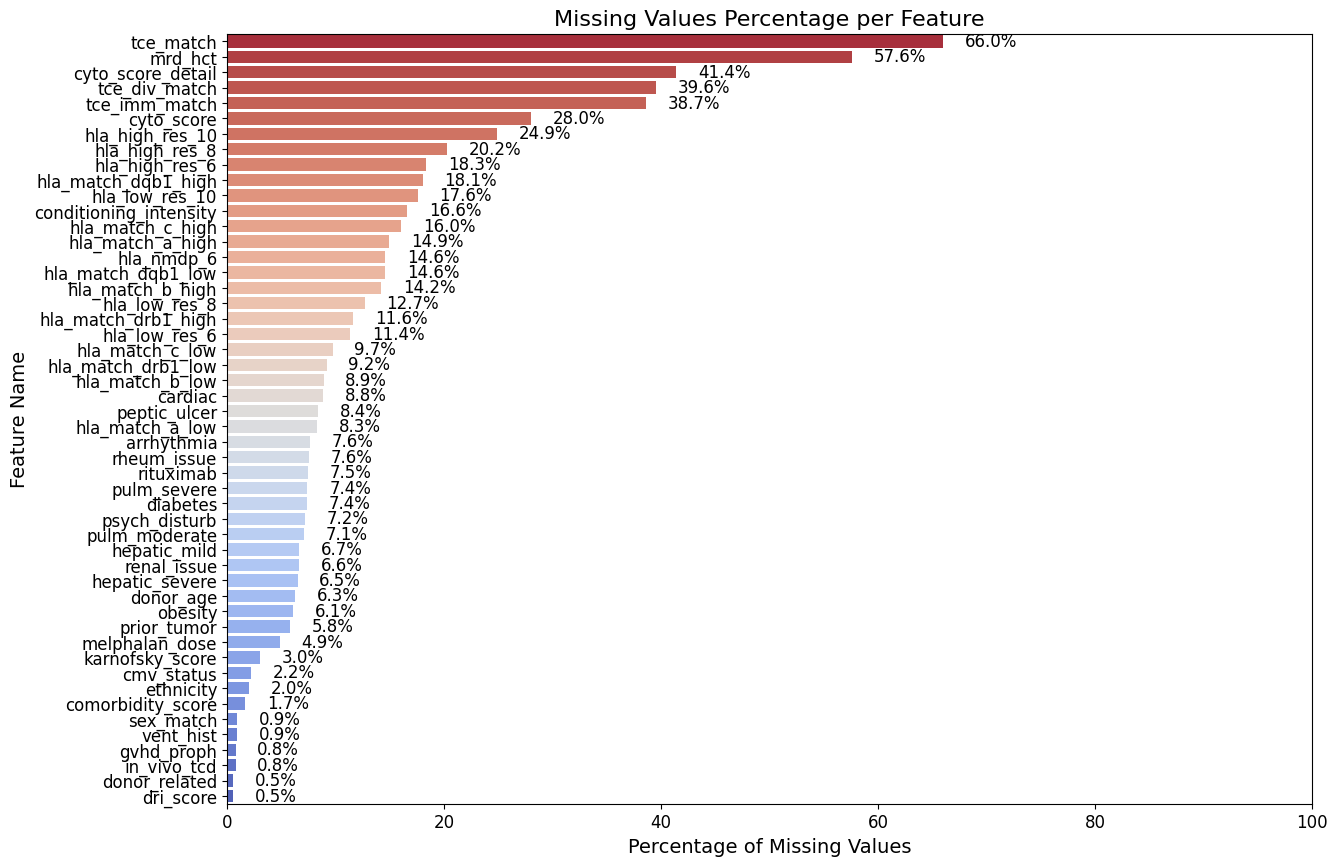

In [17]:
# Calculate missing values percentage
missing_values = train.isnull().sum() / len(train) * 100
missing_values = missing_values[missing_values > 0].sort_values(ascending=False)

# Generate a color gradient from dark blue (low missing) to red (high missing)
colors = sns.color_palette("coolwarm", len(missing_values))[::-1]

# Plot missing values with updated formatting
plt.figure(figsize=(14, 10))
bars = sns.barplot(y=missing_values.index, x=missing_values.values, palette=colors)

# Set x-axis to always go up to 100%
plt.xlim(0, 100)

# Labels and title
plt.xlabel("Percentage of Missing Values", fontsize=14)
plt.ylabel("Feature Name", fontsize=14)
plt.title("Missing Values Percentage per Feature", fontsize=16)

# Rotate x-axis ticks for better visibility
plt.xticks(fontsize=12)
plt.yticks(fontsize=12, rotation=0)

# Annotate each bar with its missing percentage
for bar, value in zip(bars.patches, missing_values.values):
    plt.text(bar.get_width() + 2, bar.get_y() + bar.get_height()/2, 
             f"{value:.1f}%", ha='left', va='center', fontsize=12, color='black')

plt.show()

Uh-oh! Some features are incomplete. For example, we see that `tce_match` has a lot of missing values!  
*(TCE Match refers to a specific type of immune match between donors and recipients in HCT transplants. If it’s missing, does it mean the match was unknown or not relevant? We’ll have to decide later!)*  

What should we do?

We have three options:
1. Fill in (impute) the missing values using the mean, median, or mode.
2. Drop the feature if it’s mostly empty.
3. Treat missing values as a separate category—sometimes missing data itself carries meaning!

Let's check out some important feature distributions:
- `age_at_hct`: Age of the patient at the time of HCT.
- `comorbidity_score`: Score representing the patient's health issues.
- `efs_time`: Event-Free Survival time in months.

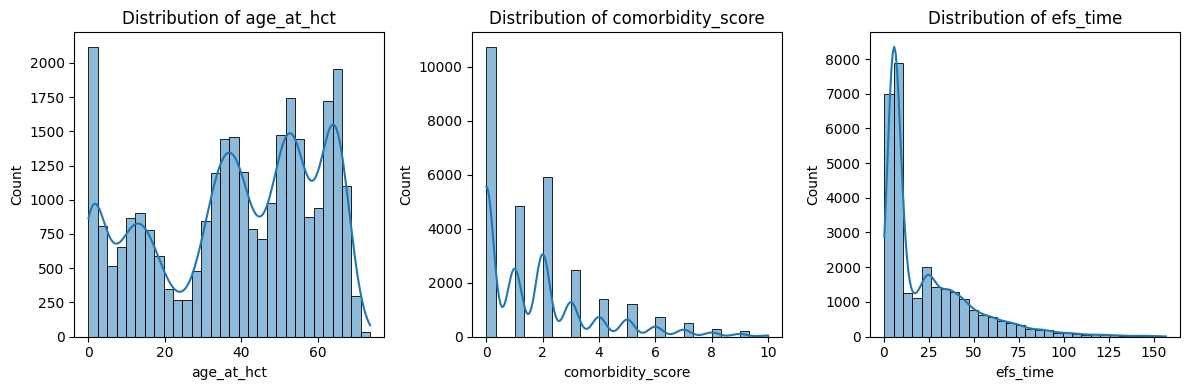

In [18]:
features = ["age_at_hct", "comorbidity_score", "efs_time"]
plt.figure(figsize=(12, 4))

for i, feature in enumerate(features):
    plt.subplot(1, 3, i + 1)
    sns.histplot(train[feature], bins=30, kde=True)
    plt.title(f"Distribution of {feature}")

plt.tight_layout()
plt.show()

Each patient with efs=1 had an event, and the time before event was efs_time. Each patient with efs=0 we do not know if they had an event or did not have an event. All we know is that they were without event for at least efs_time long. To summarize, each efs=1 was without event for exactly efs_time. And each efs=0 was without event for at least efs_time.

We’re predicting event-free survival (EFS), meaning whether a patient remained alive without complications.
If we have way more 0s than 1s, our model might be biased!

Let's see the distribution of the EFS field:

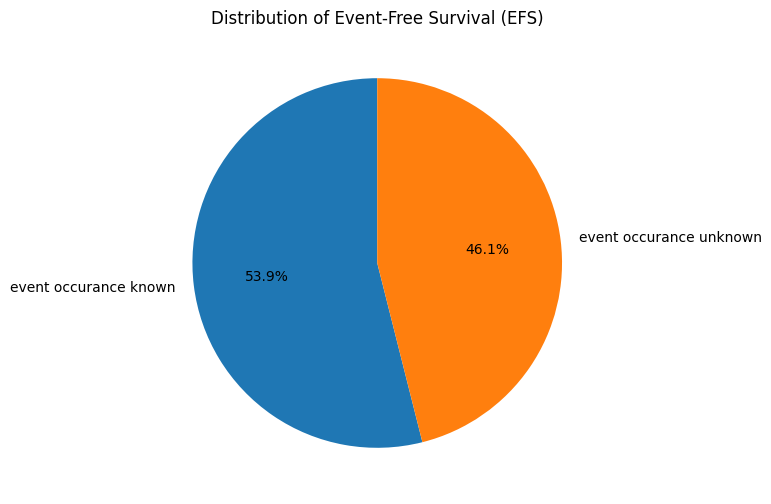

In [19]:
plt.figure(figsize=(6, 6))
labels = ['event occurance known', 'event occurance unknown']
efs_counts = train['efs'].value_counts()
plt.pie(efs_counts, labels=labels, autopct='%1.1f%%', startangle=90)
plt.title("Distribution of Event-Free Survival (EFS)") 
plt.ylabel('')
plt.show()

Let's now check if older patients have different survival rates.

C:\Users\wolfe\AppData\Local\Temp\ipykernel_17264\3167811157.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x=train["efs"], y=train["age_at_hct"], palette="muted")


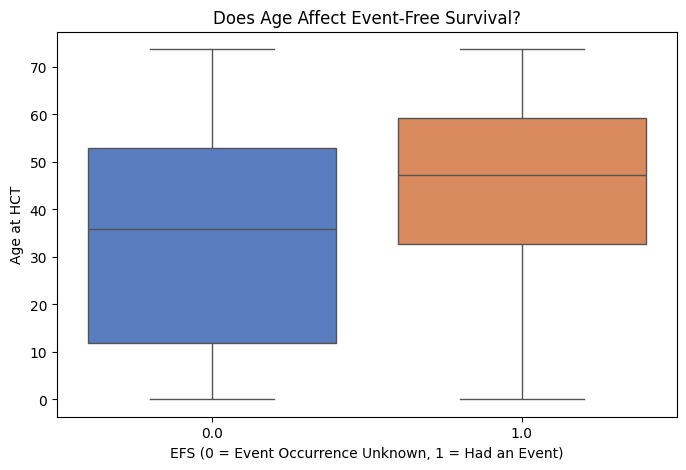

In [20]:
plt.figure(figsize=(8, 5))
sns.boxplot(x=train["efs"], y=train["age_at_hct"], palette="muted")
plt.title("Does Age Affect Event-Free Survival?")
plt.xlabel("EFS (0 = Event Occurrence Unknown, 1 = Had an Event)")
plt.ylabel("Age at HCT")
plt.show()

This suggests that older patients are more likely to have an event after HCT.

Let’s see if sicker patients have lower survival chances.

C:\Users\wolfe\AppData\Local\Temp\ipykernel_17264\3776801928.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x=train["efs"], y=train["comorbidity_score"], palette="muted")


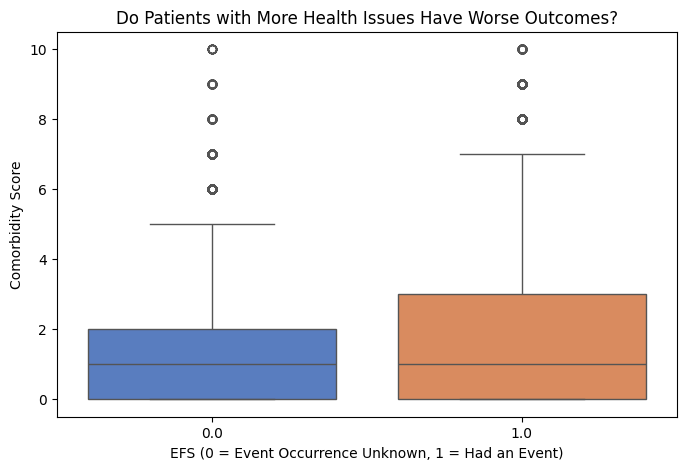

In [21]:
plt.figure(figsize=(8, 5))
sns.boxplot(x=train["efs"], y=train["comorbidity_score"], palette="muted")
plt.title("Do Patients with More Health Issues Have Worse Outcomes?")
plt.xlabel("EFS (0 = Event Occurrence Unknown, 1 = Had an Event)")
plt.ylabel("Comorbidity Score")
plt.show()

So, it seems like having more health issues increases the risk of complications. Makes sense, right? If a patient is already dealing with multiple conditions, recovery might be harder.

But wait! There are some surprises:
* A few patients with low comorbidity scores still had events.
* Some with high scores still remained event-free.

That means comorbidity isn’t the only factor affecting survival—other things like age, donor match, and treatment type might also be important.

Alright, we’ve noticed some patterns in age and comorbidity score, but are these differences statistically significant? 

To find out, we ran a Mann-Whitney U test, which checks whether the distributions of these features are truly different for patients who had an event (efs=1) vs. those who didn’t (efs=0).

In [22]:
def run_mannwhitney(feature):
    group_0 = train[train['efs'] == 0][feature]
    group_1 = train[train['efs'] == 1][feature]
    stat, p_value = mannwhitneyu(group_0, group_1, alternative="two-sided")
    print(f"🔎 Mann-Whitney U test for {feature}: p-value = {p_value:.4f}")
    if np.isnan(p_value):
        print(" Unable to determine significance due to NaN p-value.")
    elif p_value < 0.05:
        print(" This feature significantly impacts survival outcomes!")
    else:
        print(" No significant effect detected.")

# Run test for both age and comorbidity score
run_mannwhitney("age_at_hct")
run_mannwhitney("comorbidity_score")

🔎 Mann-Whitney U test for age_at_hct: p-value = 0.0000
 This feature significantly impacts survival outcomes!
🔎 Mann-Whitney U test for comorbidity_score: p-value = nan
 Unable to determine significance due to NaN p-value.


Since age significantly impacts survival, we should keep it as a key feature in our model.

Comorbidity score may not be useful on its own, but before removing it, we should try feature engineering—maybe grouping patients into risk levels could reveal stronger patterns!

Sometimes, two features are so similar that they provide the same information.
If this happens, we might remove one to make our model simpler.

let's explore the relationships between numerical features.
Correlations can help us identify redundant features, where one variable provides almost the same information as another.
High correlation (close to 1 or -1) means we might consider removing one of the features to avoid redundancy.

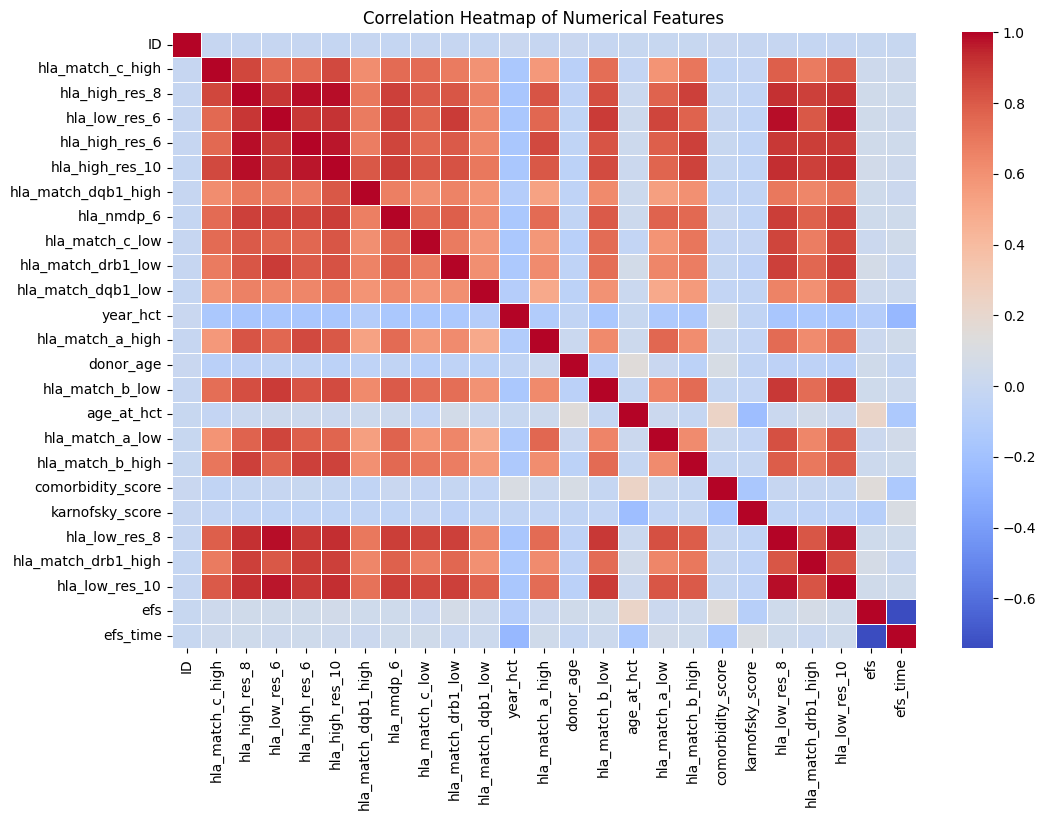

In [23]:
# Generate a correlation heatmap
plt.figure(figsize=(12, 8))
corr_matrix = train.corr(numeric_only=True)  # Only numerical columns
sns.heatmap(corr_matrix, cmap="coolwarm", annot=False, linewidths=0.5)
plt.title("Correlation Heatmap of Numerical Features")
plt.show()

1. Some Features Are Almost Twins!
Many HLA match features (hla_match_*, hla_high_res_*) are strongly correlated. This makes sense! They’re all measuring similar compatibility factors between donors and recipients.

Do we really need all of them? Maybe not! We might remove some duplicates to keep things simple.

2. Survival Time (efs_time) Seems Hard to Predict!

	efs_time doesn’t have strong correlations with most features.
	This tells us that survival time depends on many small factors rather than one big predictor.

3. Age and Donor Age:
	* Patients (age_at_hct) and their donors (donor_age) show some relationship, but it's not very strong.

4. What About Health Scores?
	* Comorbidity score and Karnofsky score have some level of correlation with each other.
	* This makes sense! A patient with more health issues (high comorbidity) probably has a lower Karnofsky score (worse physical condition).

The efs_time feature tells us how long a patient remained event-free.
Let’s see how it’s distributed!

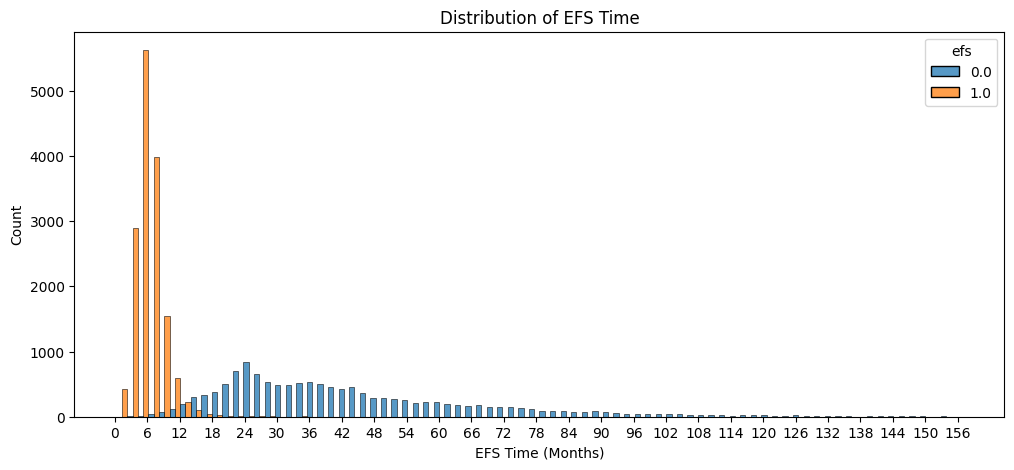

In [24]:
import matplotlib.pyplot as plt  # Ensure this import is present

# The rest of the plotting code remains the same
plt.figure(figsize=(12, 5))
sns.histplot(data=train, x='efs_time', bins=80, hue="efs", multiple="dodge")
max_val = train['efs_time'].max()
xticks = np.arange(0, max_val + 1, 6)

plt.xticks(xticks)
plt.xlabel('EFS Time (Months)')
plt.ylabel('Count')
plt.title('Distribution of EFS Time')
plt.show()

As we can see, almost all known events occur within a year post-HCT.
As for the unkown events:

In [25]:
train.loc[(train.efs == 0) & (train.year_hct >= 2020)]

,ID,dri_score,psych_disturb,cyto_score,diabetes,hla_match_c_high,hla_high_res_8,tbi_status,arrhythmia,hla_low_res_6,...,tce_div_match,donor_related,melphalan_dose,hla_low_res_8,cardiac,hla_match_drb1_high,pulm_moderate,hla_low_res_10,efs,efs_time
9747,9747,Intermediate - TED AML case <missing cytogenetics,No,TBD,No,1.0,4.0,TBI + Cy +- Other,No,NaN,...,NaN,Related,NaN,NaN,No,1.0,No,NaN,0.0,11.709
14796,14796,N/A - pediatric,NaN,NaN,No,2.0,8.0,No TBI,NaN,6.0,...,Permissive mismatched,Related,"N/A, Mel not given",8.0,NaN,2.0,No,10.0,0.0,12.293


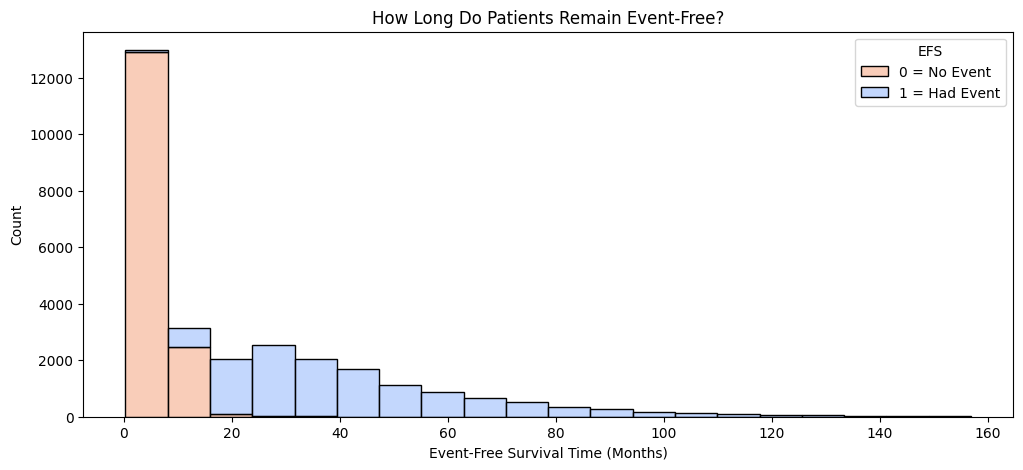

In [26]:
# Group survival times into 6-month bins
train["efs_time_bins"] = pd.cut(train["efs_time"], bins=np.arange(0, train["efs_time"].max()+6, 6))

plt.figure(figsize=(12, 5))
sns.histplot(data=train, x="efs_time", bins=20, hue="efs", multiple="stack", palette="coolwarm", alpha=0.7)
plt.xlabel("Event-Free Survival Time (Months)")
plt.ylabel("Count")
plt.title("How Long Do Patients Remain Event-Free?")
plt.legend(title="EFS", labels=["0 = No Event", "1 = Had Event"])
plt.show()

As we can see, the data features equal representation across recipient racial categories